In [1]:
pip install --upgrade pyod


[notice] A new release of pip available: 22.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install combo


[notice] A new release of pip available: 22.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
from pandas import json_normalize
import json
from datetime import datetime
import pytz
import matplotlib.pyplot as plt
import ruptures as rpt
from collections import Counter

In [4]:
columns = ['sensors.battery.temp',
       'sensors.battery.percent', 'sensors.battery.solarmv',
       'sensors.battery.current', 'sensors.battery.voltage',
       'sensors.battery.solarma', 'sensors.battery.charging',
        'solar_power', 'battery_power','power_difference']

In [5]:
# Reading back and setting the MultiIndex
labelled_data = pd.read_feather('MTDataBatch1\Labelled Data\Labelled Batch 1 - Updated.feather')
labelled_data.set_index(['DeviceId', 'time'], inplace=True)
# labelled_data

In [6]:
labelled_data

Id  \
DeviceId        time                                   
015262001277846 2021-04-21 03:18:26+10:00      10046   
                2021-04-21 03:17:52+10:00      10049   
                2021-04-21 03:27:29+10:00      15189   
                2021-04-21 03:28:29+10:00      15190   
                2021-04-21 03:21:30+10:00      15191   
...                                              ...   
015262001276442 2021-11-22 13:01:23+11:00  195389569   
                2021-11-22 13:04:17+11:00  195391320   
                2021-11-23 13:05:02+11:00  196545125   
                2021-11-24 13:05:36+11:00  197957676   
                2021-11-24 13:05:02+11:00  197957683   

                                                                    CreatedAt  \
DeviceId        time                                                            
015262001277846 2021-04-21 03:18:26+10:00  2021-04-20 17:18:57.3601057 +00:00   
                2021-04-21 03:17:52+10:00  2021-04-20 17:18:57.9206698 +00:00   
                2021-04-21 03:27:29+10:00  2021-04-20 17:30:00.0973275 +00:00   
                2021-04-21 03:28:29+10:00  2021-04-20 17:30:00.5204188 +00:00   
                2021-04-21 03:21:30+10:00  2021-04-20 17:30:00.6604193 +00:00   
...                                                                       ...   
015262001276442 2021-11-22 13:01:23+11:00  2021-11-22 02:02:07.3194074 +00:00   
                2021-11-22 13:04:17+11:00  2021-11-22 02:04:57.8307232 +00:00   
                2021-11-23 13:05:02+11:00  2021-11-23 02:05:44.6179891 +00:00   
                2021-11-24 13:05:36+11:00  2021-11-24 02:06:18.7314233 +00:00   
                2021-11-24 13:05:02+11:00  2021-11-24 02:06:19.3460223 +00:00   

                                                                    UpdatedAt  \
DeviceId        time                                                            
015262001277846 2021-04-21 03:18:26+10:00  2021-04-20 17:18:57.4751133 +00:00   
                2021-04-21 03:17:52+10:00  2021-04-20 17:18:58.0006530 +00:00   
                2021-04-21 03:27:29+10:00  2021-04-20 17:30:00.1973672 +00:00   
                2021-04-21 03:28:29+10:00  2021-04-20 17:30:00.6554035 +00:00   
                2021-04-21 03:21:30+10:00  2021-04-20 17:30:00.7254268 +00:00   
...                                                                       ...   
015262001276442 2021-11-22 13:01:23+11:00  2021-11-22 02:02:07.4609948 +00:00   
                2021-11-22 13:04:17+11:00  2021-11-22 02:04:57.9257593 +00:00   
                2021-11-23 13:05:02+11:00  2021-11-23 02:05:44.7707739 +00:00   
                2021-11-24 13:05:36+11:00  2021-11-24 02:06:18.8826478 +00:00   
                2021-11-24 13:05:02+11:00  2021-11-24 02:06:19.4060168 +00:00   

                                          State             timeStamp  \
DeviceId        time                                                    
015262001277846 2021-04-21 03:18:26+10:00     1  2021-04-20T17:18:26Z   
                2021-04-21 03:17:52+10:00     1  2021-04-20T17:17:52Z   
                2021-04-21 03:27:29+10:00     1  2021-04-20T17:27:29Z   
                2021-04-21 03:28:29+10:00     1  2021-04-20T17:28:29Z   
                2021-04-21 03:21:30+10:00     1  2021-04-20T17:21:30Z   
...                                         ...                   ...   
015262001276442 2021-11-22 13:01:23+11:00     1  2021-11-22T02:01:23Z   
                2021-11-22 13:04:17+11:00     1  2021-11-22T02:04:17Z   
                2021-11-23 13:05:02+11:00     1  2021-11-23T02:05:02Z   
                2021-11-24 13:05:36+11:00     1  2021-11-24T02:05:36Z   
                2021-11-24 13:05:02+11:00     1  2021-11-24T02:05:02Z   

                                             event  sensors.battery.extpower  \
DeviceId        time                                                           
015262001277846 2021-04-21 03:18:26+10:00   moving                     False   
                2021-04

In [7]:
labelled_data = labelled_data.sort_index(level=['DeviceId', 'time'])

In [8]:
numberOfDevices = len(labelled_data.groupby(level=0))
numberOfDevices

35

In [9]:
column_list = list(labelled_data.columns)
# for column in column_list:
#     print(column)
#     print(labelled_data[column].isnull().values.any())
#     print("-------------------")

In [10]:
len(labelled_data.columns)

31

In [11]:
solar_power = labelled_data['solar_power']

In [14]:
# Multi variate forecasting means we take multiple parameters (X), to forecast one parameter (y)

def df_to_X_y(df, window_size = 5):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np) - window_size):
        row = df_as_np[i:i+window_size]
        X.append(row)
        label = df_as_np[i+window_size]
        y.append(label)
    return np.array(X), np.array(y)   

In [15]:
WINDOW_SIZE = 5
X,y = df_to_X_y(solar_power)
X.shape, y.shape

((1684078, 5), (1684078,))

In [16]:
train_size = int(len(labelled_data) * 0.80)
test_size = len(labelled_data) - train_size

In [17]:
# Training data : take all rows, and only device feature columns (From "sensors.battery.temp" to "power_difference")
# Not considering boolean column sensors.battery.extpower as we arent normalizing the data later for Forecasting
train_data = labelled_data.iloc[0:train_size,7:29]
test_data = labelled_data.iloc[train_size:len(labelled_data),7:29]
# Drop columns that have string values, or even NaN values 
# Manual Inspection proved them as non important for malfunction detectio.
train_data = train_data.drop('location.source', axis=1)
train_data = train_data.drop('location.numSats', axis=1)
train_data = train_data.drop('sensors.accelerometer.y', axis=1)
train_data = train_data.drop('sensors.accelerometer.x', axis=1)
train_data = train_data.drop('sensors.accelerometer.z', axis=1)
train_data = train_data.drop('sensors.battery.charging', axis=1)
test_data = test_data.drop('location.source', axis=1)
test_data = test_data.drop('location.numSats', axis=1)
test_data = test_data.drop('sensors.accelerometer.y', axis=1)
test_data = test_data.drop('sensors.accelerometer.x', axis=1)
test_data = test_data.drop('sensors.accelerometer.z', axis=1)
test_data = test_data.drop('sensors.battery.charging', axis=1)
# Labels is the array of values in "isDeviceWorking" -  convert to array of inetgers (0 or 1 values)
labels = labelled_data.iloc[:,29].values


In [18]:
train_data.dtypes

sensors.battery.temp       float64
sensors.battery.percent    float64
sensors.battery.solarmv      int64
sensors.battery.current      int64
sensors.battery.voltage      int64
sensors.battery.solarma      int64
location.bearing           float64
location.floor               int64
location.altitude          float64
location.longitude         float64
location.latitude          float64
location.speed               int64
location.accuracy          float64
solar_power                float64
battery_power              float64
power_difference           float64
dtype: object

In [19]:
deviceWorkingLabels = labelled_data[['isDeviceWorking']].copy()
deviceWorkingLabels['isDeviceWorking'] = deviceWorkingLabels['isDeviceWorking'].astype(int)
deviceWorkingLabels

isDeviceWorking
DeviceId        time                                      
015262001090339 2021-06-11 12:27:45+10:00                1
                2021-06-11 12:34:17+10:00                1
                2021-06-11 16:34:25+10:00                1
                2021-06-11 20:34:39+10:00                1
                2021-06-12 00:35:02+10:00                1
...                                                    ...
015262001281806 2021-11-09 09:42:02+11:00                0
                2021-11-10 09:42:09+11:00                0
                2021-11-10 09:45:07+11:00                0
                2021-11-11 09:45:49+11:00                0
                2021-11-11 09:46:42+11:00                0

[1684083 rows x 1 columns]

In [20]:
train_data_label = deviceWorkingLabels.iloc[0:train_size,:]
test_data_label = deviceWorkingLabels.iloc[train_size:len(deviceWorkingLabels),:]

In [21]:
testdeviceIDs = set(test_data.index.get_level_values(0).tolist())
print(testdeviceIDs)

{'015262001278133', '015262001278372', '015262001278323', '015262001281806', '015262001278513', '015262001278422', '015262001278315'}


In [22]:
# LSTM is a type of RNN - we need sequences that act as an input to the LSTM. Chunks of timestamps are used as sequences

# Create sequences for each device. Take timestamps for each deviceId and form sequences taking 10 time steps at a time.
def create_dataset(X, y, time_steps = 1):
    Xs, ys = [],[]
#     Get list of devieIDs in datatset
    deviceIDs = set(X.index.get_level_values(0).tolist())
#     X = X_df.to_numpy()
#     y = y_df.tonumpy()
    for device in deviceIDs:
        xForDeviceId = X[X.index.get_level_values('DeviceId') == device]
        yForDeviceId = y[y.index.get_level_values('DeviceId') == device]
        for i in range(len(xForDeviceId) - time_steps):
    #         Take the value of current time step (x) and do a bit of indexing. 
            v = xForDeviceId.iloc[i:(i + time_steps)].to_numpy()
            Xs.append(v)
            ys.append(yForDeviceId.iloc[i + time_steps])
            
    return np.array(Xs), np.array(ys)

In [23]:
# Convert train dataset into sequences
# Start with 5 time steps as history.

TIME_STEPS = 5

X_train, y_train = create_dataset(train_data, train_data['solar_power'], TIME_STEPS)
X_test, y_test = create_dataset(test_data,test_data['solar_power'],TIME_STEPS)

In [24]:
# The shape of the created sequence dataset: 
# it's a 3-D tensor which contains the timeseries, time step (history), and number of features
X_train.shape, y_train.shape

((1347121, 5, 16), (1347121,))

In [25]:
# Create sequences for each device. Take timestamps for each deviceId and form sequences taking 10 time steps at a time.
def create_dataset_new(X, y, time_steps = 1):
    Xs, ys = [],[]
    index_of_sequences = []
#     Get list of devieIDs in datatset
    deviceIDs = set(X.index.get_level_values(0).tolist())
    
    for device in deviceIDs:
        xForDeviceId = X[X.index.get_level_values('DeviceId') == device]
        yForDeviceId = y[y.index.get_level_values('DeviceId') == device]
        for i in range(len(xForDeviceId) - time_steps):
    #         Take the value of current time step (x) and do a bit of indexing. 
            v = xForDeviceId.iloc[i:(i + time_steps)]
            Xs.append(v)
            ys.append(yForDeviceId.iloc[i + time_steps])
#             Store the index of the forecasted time for the device.
            index_of_sequences.append(yForDeviceId.iloc[i + time_steps -1:i + time_steps].index.tolist()[0])
#             print(index_of_sequences)
            
    return np.array(Xs), np.array(ys), index_of_sequences

In [26]:
# Convert train dataset into sequences
# Start with 10 time steps as history.

# TIME_STEPS = 5

X_train_new, y_train_new, train_index_list= create_dataset_new(train_data, train_data['solar_power'], TIME_STEPS)
len(train_index_list)

1347121

In [27]:
X_test_new, y_test_new, test_index_list = create_dataset_new(test_data,test_data['solar_power'],TIME_STEPS)

In [28]:
test_index_list

[('015262001278133',
  Timestamp('2021-06-15 01:14:42+1000', tz='Australia/Sydney')),
 ('015262001278133',
  Timestamp('2021-06-15 01:15:44+1000', tz='Australia/Sydney')),
 ('015262001278133',
  Timestamp('2021-06-15 01:16:43+1000', tz='Australia/Sydney')),
 ('015262001278133',
  Timestamp('2021-06-15 01:17:45+1000', tz='Australia/Sydney')),
 ('015262001278133',
  Timestamp('2021-06-15 01:19:03+1000', tz='Australia/Sydney')),
 ('015262001278133',
  Timestamp('2021-06-15 01:20:05+1000', tz='Australia/Sydney')),
 ('015262001278133',
  Timestamp('2021-06-15 01:21:04+1000', tz='Australia/Sydney')),
 ('015262001278133',
  Timestamp('2021-06-15 01:22:42+1000', tz='Australia/Sydney')),
 ('015262001278133',
  Timestamp('2021-06-15 01:23:21+1000', tz='Australia/Sydney')),
 ('015262001278133',
  Timestamp('2021-06-15 01:24:06+1000', tz='Australia/Sydney')),
 ('015262001278133',
  Timestamp('2021-06-15 01:25:19+1000', tz='Australia/Sydney')),
 ('015262001278133',
  Timestamp('2021-06-15 01:26:07+

In [29]:
# The sequences form the input to LSTM Autoencoder
# Idea behind this is to train a model based on our data, measure the error post training. 
# If the error is above a threshold, the model cannot reconstruct the data, indicative of an anomaly (predictive)

In [30]:
import numpy as np
from tensorflow.keras.utils import to_categorical
from keras import models
from keras import layers
from keras.datasets import imdb
from time import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, RepeatVector, TimeDistributed
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

In [31]:
model = Sequential()
# Add an LSTM Layer with 64 units
model.add(LSTM(
    units=64, 
    input_shape=(X_train.shape[1], X_train.shape[2])
))


model.add(Dense(8,'relu'))

model.add(Dense(1, 'linear'))

# model.compile(loss='mae', optimizer = 'adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                20736     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 21,265
Trainable params: 21,265
Non-trainable params: 0
_________________________________________________________________


In [32]:
# save only the best model, ie the one with the least validation loss
cp = ModelCheckpoint('model/',save_best_only = True)

In [33]:
# Learning rate - higher the rate is the faster it is going to decrease the loss
model.compile(loss = MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [34]:
# Train the model
# Important: In time series data, do not shuffle the data because data is history dependent
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    shuffle = False,
    callbacks=[cp]
)

Epoch 1/10
37888/37888 [==============================] - ETA: 0s - loss: 0.0270 - root_mean_squared_error: 0.1644

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


37888/37888 [==============================] - 251s 7ms/step - loss: 0.0270 - root_mean_squared_error: 0.1644 - val_loss: 0.0187 - val_root_mean_squared_error: 0.1368
Epoch 2/10
37886/37888 [============================>.] - ETA: 0s - loss: 0.0185 - root_mean_squared_error: 0.1359

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


37888/37888 [==============================] - 264s 7ms/step - loss: 0.0185 - root_mean_squared_error: 0.1359 - val_loss: 0.0172 - val_root_mean_squared_error: 0.1313
Epoch 3/10
37888/37888 [==============================] - 233s 6ms/step - loss: 0.0180 - root_mean_squared_error: 0.1341 - val_loss: 0.0174 - val_root_mean_squared_error: 0.1319
Epoch 4/10
37888/37888 [==============================] - ETA: 0s - loss: 0.0178 - root_mean_squared_error: 0.1333

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


37888/37888 [==============================] - 242s 6ms/step - loss: 0.0178 - root_mean_squared_error: 0.1333 - val_loss: 0.0171 - val_root_mean_squared_error: 0.1309
Epoch 5/10
37888/37888 [==============================] - 232s 6ms/step - loss: 0.0176 - root_mean_squared_error: 0.1327 - val_loss: 0.0173 - val_root_mean_squared_error: 0.1315
Epoch 6/10
37884/37888 [============================>.] - ETA: 0s - loss: 0.0176 - root_mean_squared_error: 0.1326

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


37888/37888 [==============================] - 240s 6ms/step - loss: 0.0176 - root_mean_squared_error: 0.1326 - val_loss: 0.0171 - val_root_mean_squared_error: 0.1308
Epoch 7/10
37888/37888 [==============================] - 240s 6ms/step - loss: 0.0176 - root_mean_squared_error: 0.1328 - val_loss: 0.0174 - val_root_mean_squared_error: 0.1318
Epoch 8/10
37888/37888 [==============================] - 234s 6ms/step - loss: 0.0177 - root_mean_squared_error: 0.1329 - val_loss: 0.0171 - val_root_mean_squared_error: 0.1309
Epoch 9/10
37888/37888 [==============================] - 235s 6ms/step - loss: 0.0176 - root_mean_squared_error: 0.1328 - val_loss: 0.0174 - val_root_mean_squared_error: 0.1320
Epoch 10/10
37883/37888 [============================>.] - ETA: 0s - loss: 0.0176 - root_mean_squared_error: 0.1326

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


37888/37888 [==============================] - 239s 6ms/step - loss: 0.0176 - root_mean_squared_error: 0.1326 - val_loss: 0.0171 - val_root_mean_squared_error: 0.1307


In [35]:
# The RMSE and validation loss goes down with each epoch.
# Load the one which was saved
from tensorflow.keras.models import load_model
model = load_model('model/')

In [36]:
train_predictions = model.predict(X_train).flatten()

42098/42098 [==============================] - 119s 3ms/step


In [37]:
len(train_index_list)

1347121

In [38]:
train_results = pd.DataFrame(index=pd.MultiIndex.from_tuples(train_index_list, names=('DeviceId', 'time')))
train_results['Train_predictions'] = train_predictions
train_results['Actuals'] = y_train
train_results

Train_predictions   Actuals
DeviceId        time                                                  
015262001268894 2021-04-21 03:00:07+10:00           0.002299  0.000000
                2021-04-21 03:01:07+10:00           0.002299  0.000012
                2021-04-21 03:02:07+10:00           0.002299  0.000000
                2021-04-21 03:03:07+10:00           0.002299  0.000000
                2021-04-21 03:04:06+10:00           0.002299  0.000000
...                                                      ...       ...
015262001261642 2021-07-20 10:35:55+10:00           0.102129  0.000000
                2021-07-21 10:36:17+10:00           0.102129  0.043176
                2021-07-22 10:36:32+10:00           0.111123  0.007848
                2021-07-23 10:36:31+10:00           0.025463  0.019950
                2021-07-30 10:36:41+10:00          -0.002586  0.015552

[1347121 rows x 2 columns]

{'015262001268894', '015262001265908', '015262001277556', '015262001276434', '015262001277507', '015262001276244', '015262001277564', '015262001261600', '015262001276418', '015262001278133', '015262001275022', '015262001275493', '015262001105328', '015262001276442', '015262001275139', '015262001278075', '015262001277994', '015262001276483', '015262001228161', '015262001268480', '015262001276475', '015262001258648', '015262001274207', '015262001090339', '015262001277440', '015262001274561', '015262001277846', '015262001249910', '015262001261642'}
Forecasting solar_power OF SENSORS


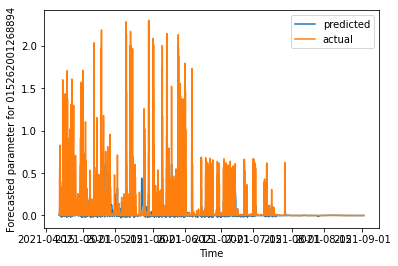

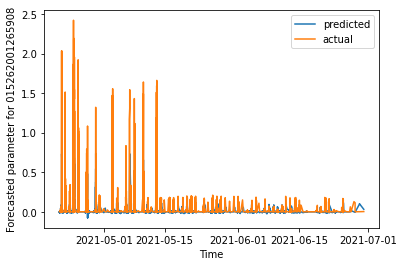

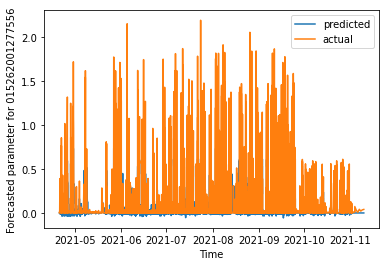

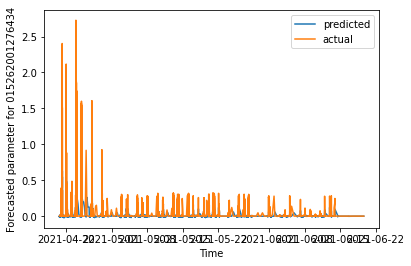

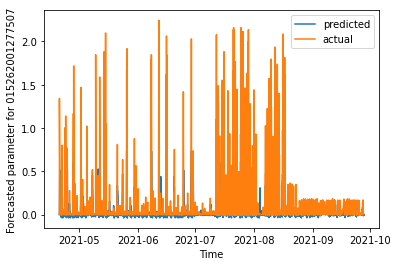

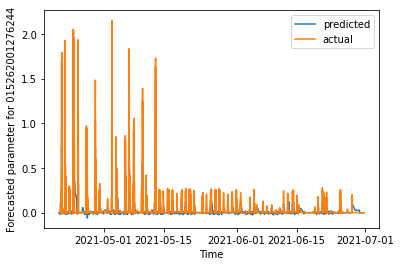

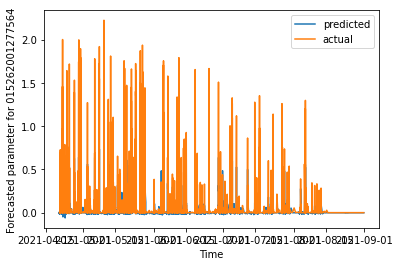

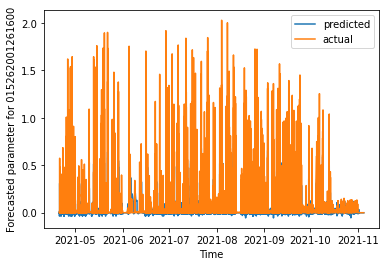

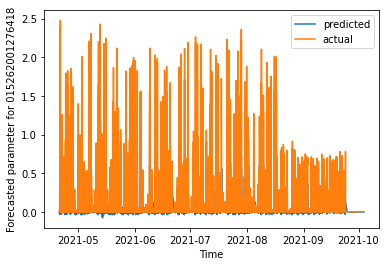

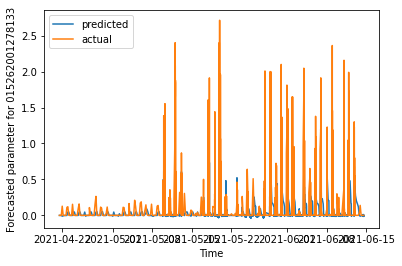

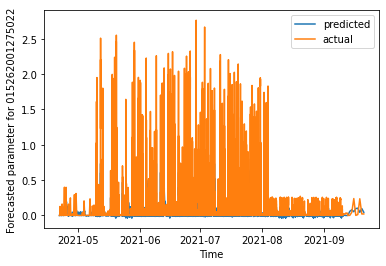

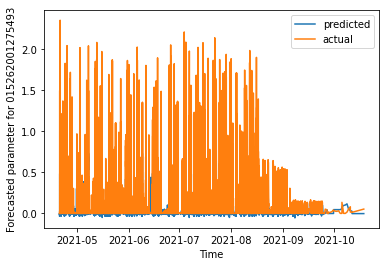

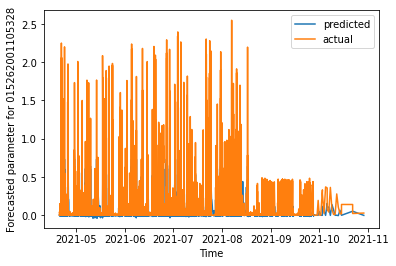

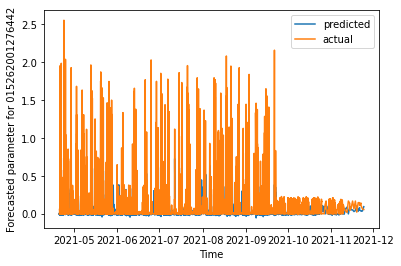

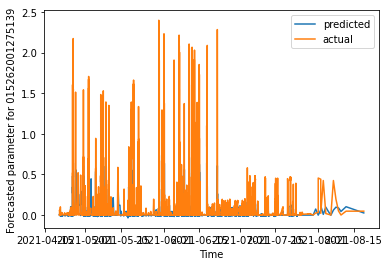

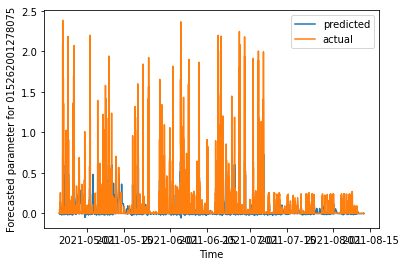

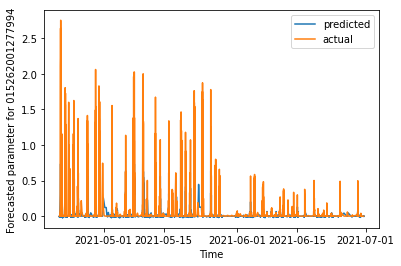

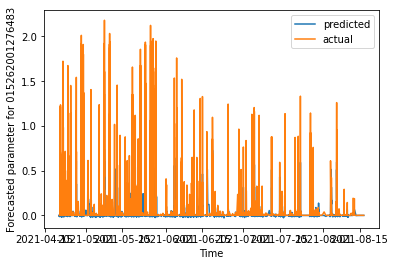

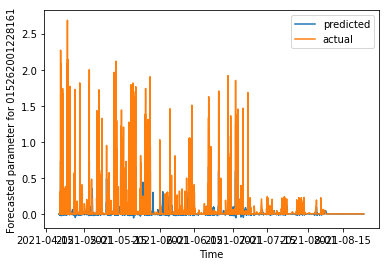

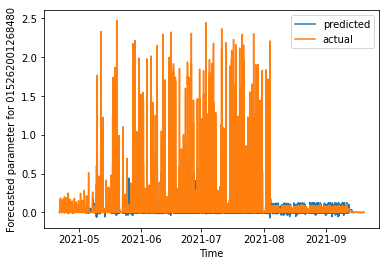

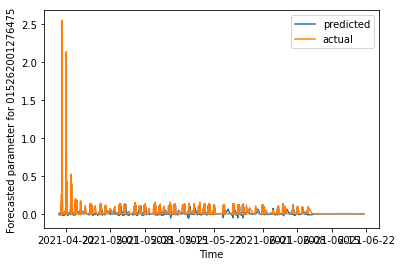

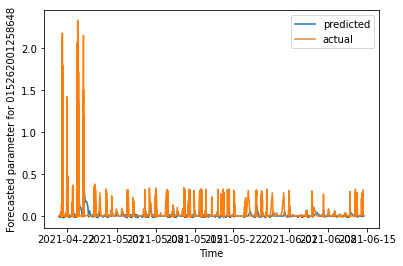

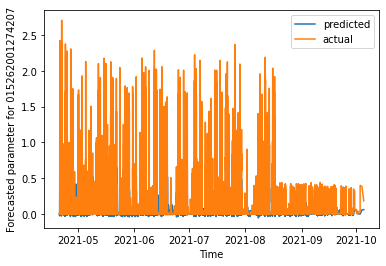

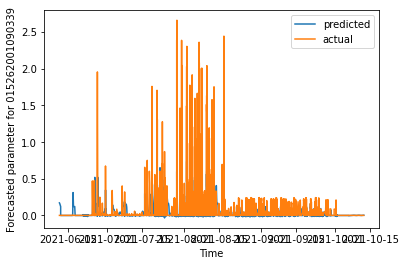

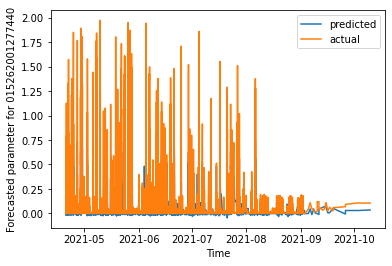

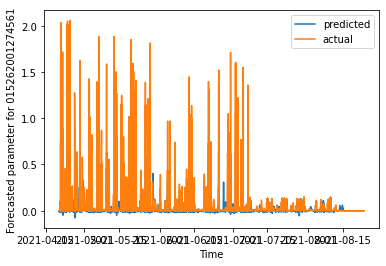

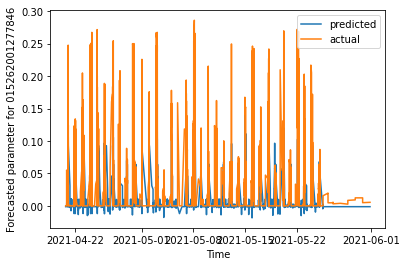

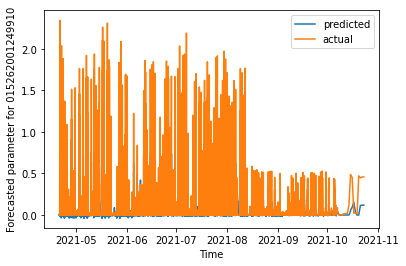

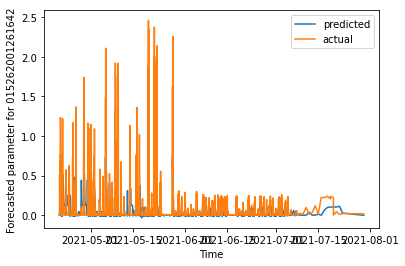

In [39]:
traindeviceIDs = set(train_results.index.get_level_values(0).tolist())
print(traindeviceIDs)
print("Forecasting solar_power OF SENSORS")
for device in traindeviceIDs:
    fig, ax = plt.subplots()
    train_preds = train_results[train_results.index.get_level_values('DeviceId') == device]
    predicted = train_preds.Train_predictions
    actual = train_preds.Actuals

    ax.plot(train_preds.index.get_level_values('time').values, predicted, label = 'predicted')
    ax.plot(train_preds.index.get_level_values('time').values, actual, label='actual')

    # Set x-axis label
    ax.set_xlabel('Time')

    # Set y-axis label
    ax.set_ylabel('Forecasted parameter for '+device)

    # Set legend
    ax.legend()

    # Show plot
    plt.show()

In [40]:
traindeviceIDs_list = list(traindeviceIDs)

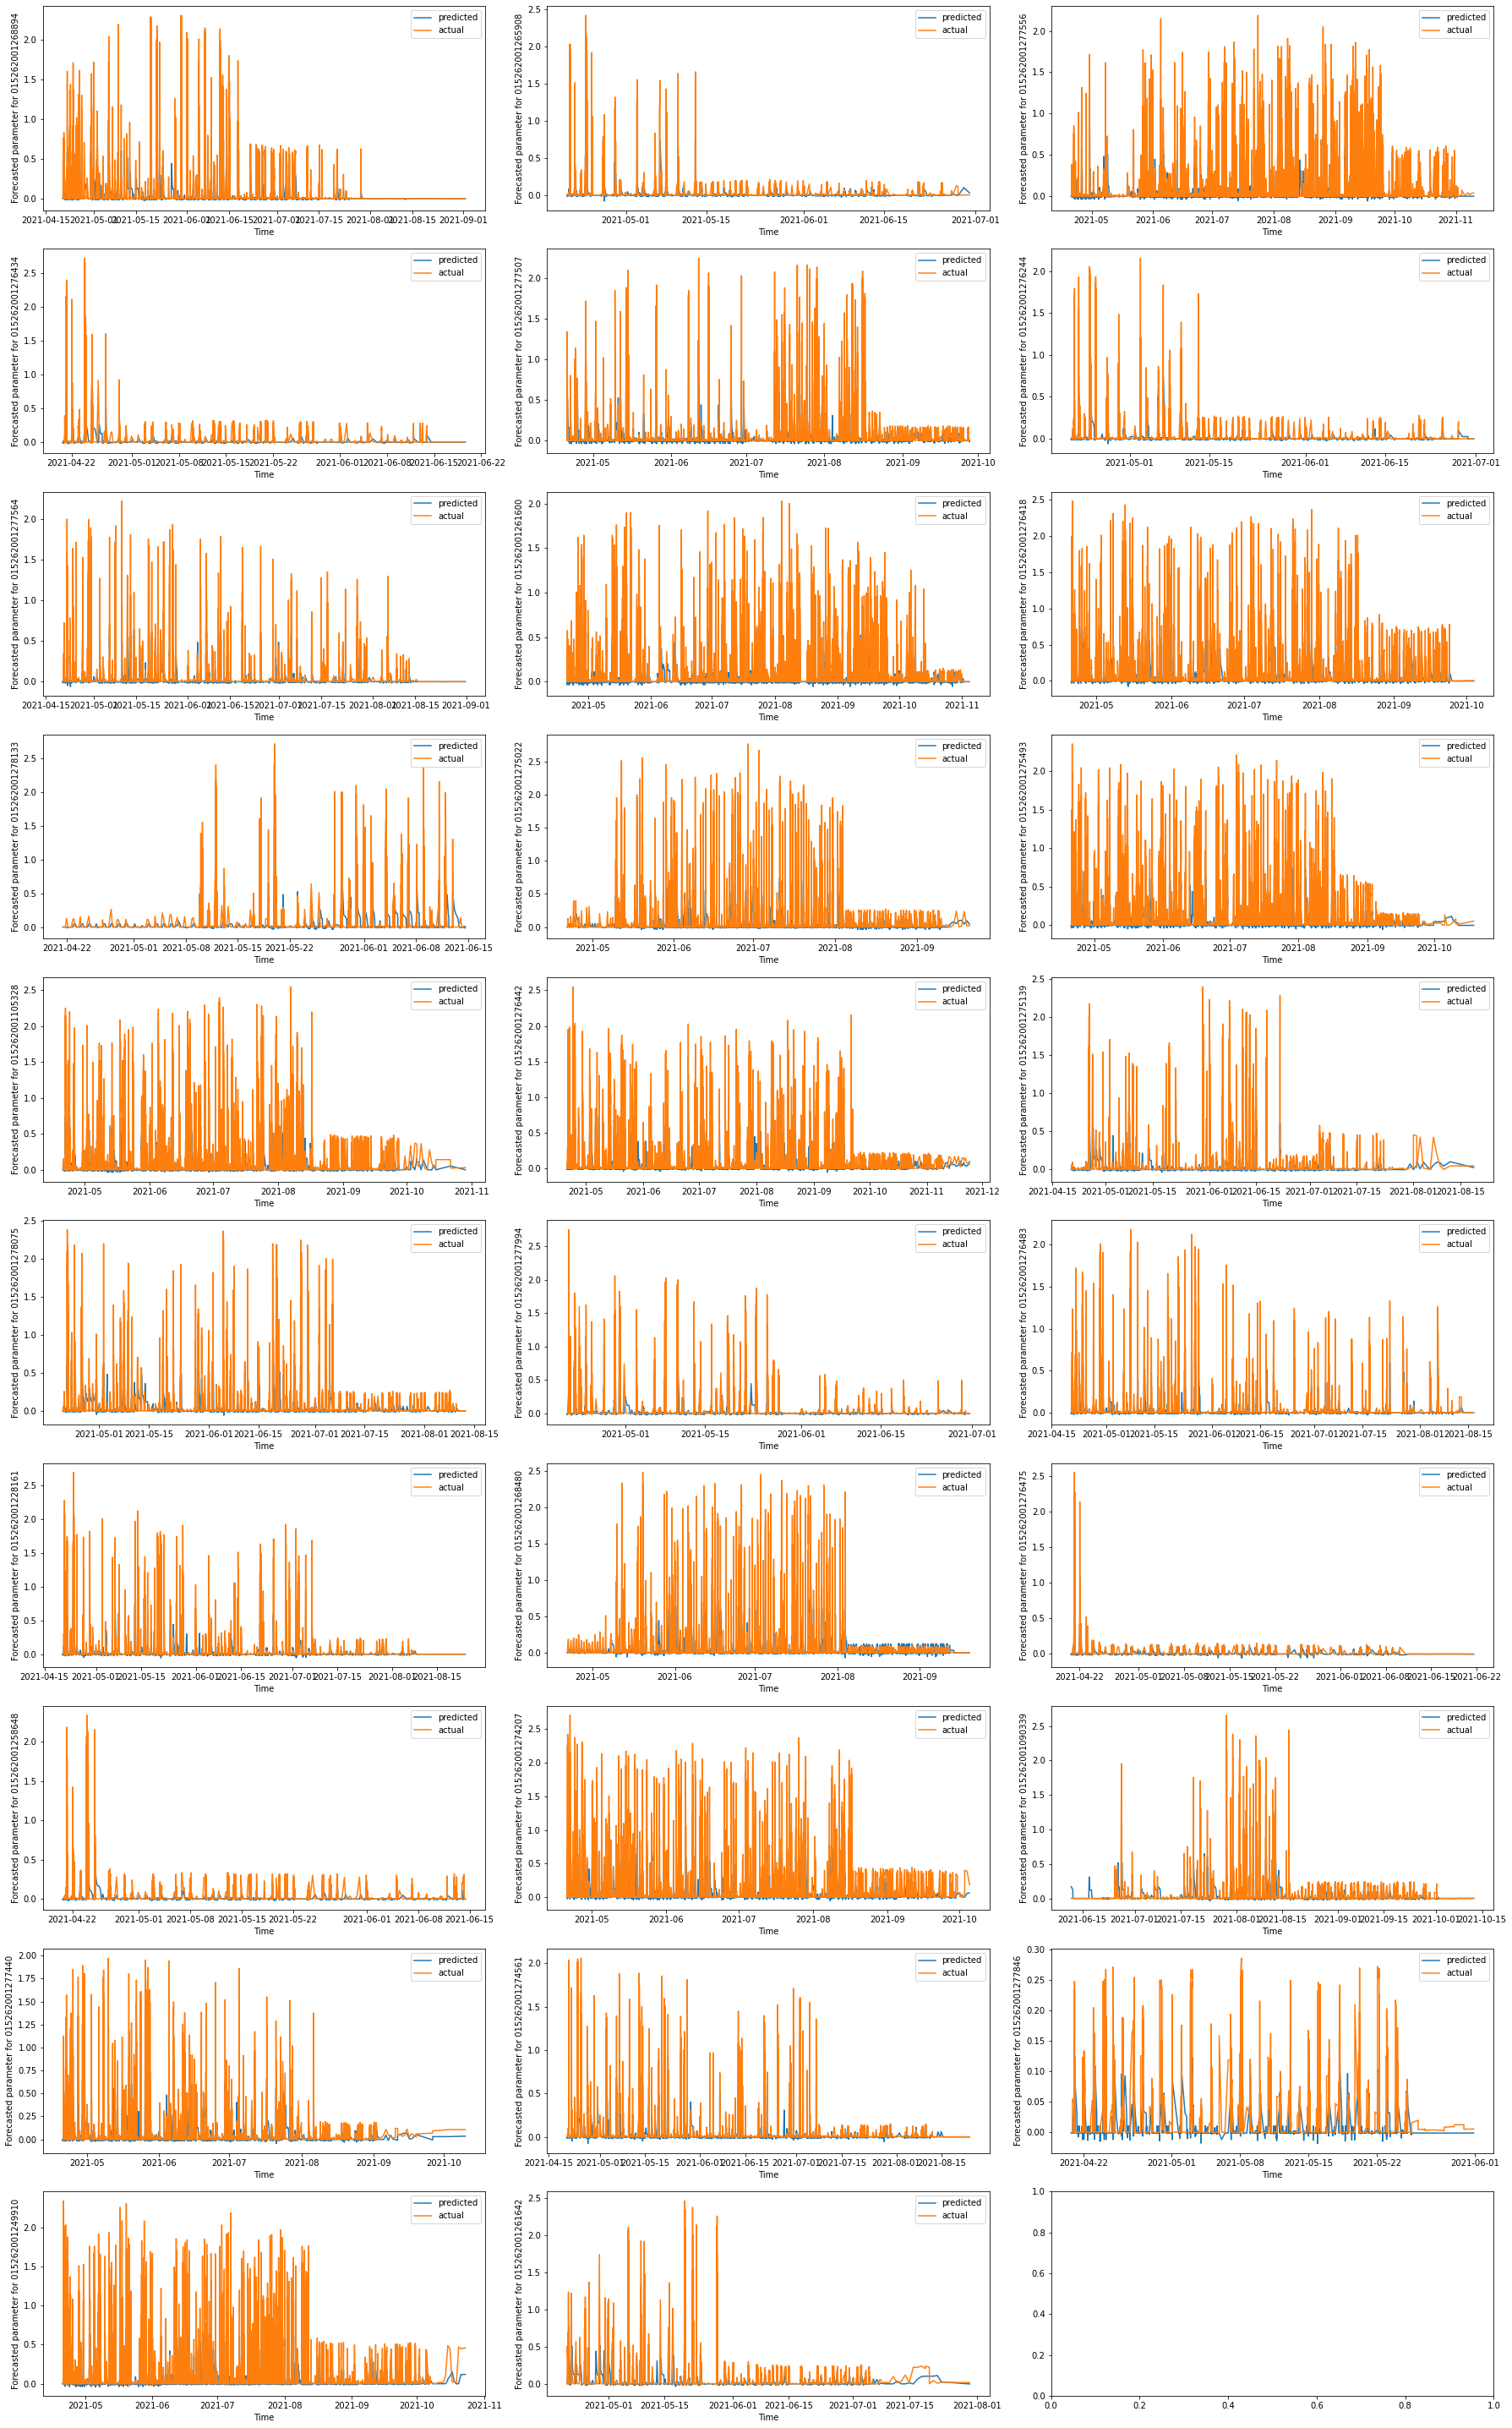

In [41]:
figure, axes = plt.subplots(10,3,figsize=(25,40))
parameter = "BATERRY TEMPERATURE"
axes = axes.flatten()
for i, ax in enumerate(axes):
# for device in traindeviceIDs:
#     fig, ax = plt.subplots()
    if i < len(traindeviceIDs_list):
        device = traindeviceIDs_list[i]
        train_preds = train_results[train_results.index.get_level_values('DeviceId') == device]
        predicted = train_preds.Train_predictions
        actual = train_preds.Actuals

        ax.plot(train_preds.index.get_level_values('time').values, predicted, label = 'predicted')
        ax.plot(train_preds.index.get_level_values('time').values, actual, label='actual')

        # Set x-axis label
        ax.set_xlabel('Time')

        # Set y-axis label
        ax.set_ylabel('Forecasted parameter for '+device)

        # Set legend
        ax.legend()
        
plt.tight_layout()
output_path = "D:\\UniMelb\\Sem 3\\4 Data\\MTDataBatch1\\Forecasted Data - solar_power.png"
plt.savefig(output_path,facecolor='white', transparent=False,dpi=600)

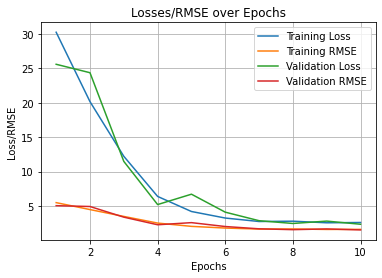

In [42]:
import matplotlib.pyplot as plt

epochs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
training_loss = [30.250, 20.1696, 12.2297, 6.4009, 4.2116, 3.2614, 2.7572, 2.8032, 2.5714, 2.6147]
training_rmse = [5.4986, 4.4911, 3.4968, 2.53, 2.0522, 1.806, 1.6605, 1.6743, 1.6036, 1.617]
validation_loss = [25.5957, 24.3707, 11.4886, 5.2181, 6.7246, 4.114, 2.8743, 2.4728, 2.8165, 2.3592]
validation_rmse = [5.0592, 4.9367, 3.3895, 2.2843, 2.5932, 2.0285, 1.6954, 1.5725, 1.6782, 1.536]

plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, training_rmse, label='Training RMSE')
plt.plot(epochs, validation_loss, label='Validation Loss')
plt.plot(epochs, validation_rmse, label='Validation RMSE')

plt.xlabel('Epochs')
plt.ylabel('Loss/RMSE')
plt.title('Losses/RMSE over Epochs')
plt.legend()
plt.grid(True)